## CoMM on trimodal Vision&Touch dataset

This notebook will show you how to use CoMM on the trimodal [Vision&Touch dataset](https://ieeexplore.ieee.org/abstract/document/9043710) [1]. It contains 3 modalities: proprioception data (as timeseries), images and force-torque data (as time series). 

The downstream binary task is to predict whether there will be contact in the next timestep or not between the robot arm and the box.

[1] Making Sense of Vision and Touch: Learning Multimodal Representations for Contact-Rich Tasks, Lee et al., IEEE Transactions on Robotics 2020

## Packages install and loading

We start by installing and loading the required packages for this notebook:

%pip install torch
%pip install omegaconf
%pip install hydra-core
%pip install pytorch-lightning
%pip install scikit-learn
%pip install torchvision
%pip install tensorboard
%pip install pandas
%pip install einops
%pip install matplotlib
%pip install gdown

In [33]:
import sys
sys.path.append("../")
import numpy as np
import timm
import torch
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from dataset.multibench import MultiBenchDataModule
from pytorch_lightning import Trainer
from pl_modules.comm import CoMM
from evaluation.linear_probe import evaluate_linear_probe
from models.mmfusion import MMFusion
from models.input_adapters import PatchedInputAdapter, SimpleFeaturesInputAdapter
from models.robotics import ForceEncoder, ProprioEncoder

## Download and visualize the data

Data need to be downloaded and extracted first (this may take a while, ~40min for 11GB, depending on your Internet connection):

In [ ]:
!wget http://downloads.cs.stanford.edu/juno/triangle_real_data.zip -O _tmp.zip
!unzip _tmp.zip
!rm _tmp.zip
!mv triangle_read_data /path/to/your/data # Replace with the path in 'dataset/catalog.json'

In [2]:
data_module_vt = MultiBenchDataModule("visionandtouch-bin", model="CoMM", 
                                        batch_size=64, num_workers=16, 
                                        modalities=["image", "force", "proprio"],
                                        augmentations=["simclr", "noise+drop", "noise"])

downstream_vt = MultiBenchDataModule("visionandtouch-bin", model="Sup", 
                                        batch_size=64, num_workers=16, 
                                        modalities=["image", "force", "proprio"],
                                        task="contact_next")

Let's have a look at the 3 modalities for a few samples: 

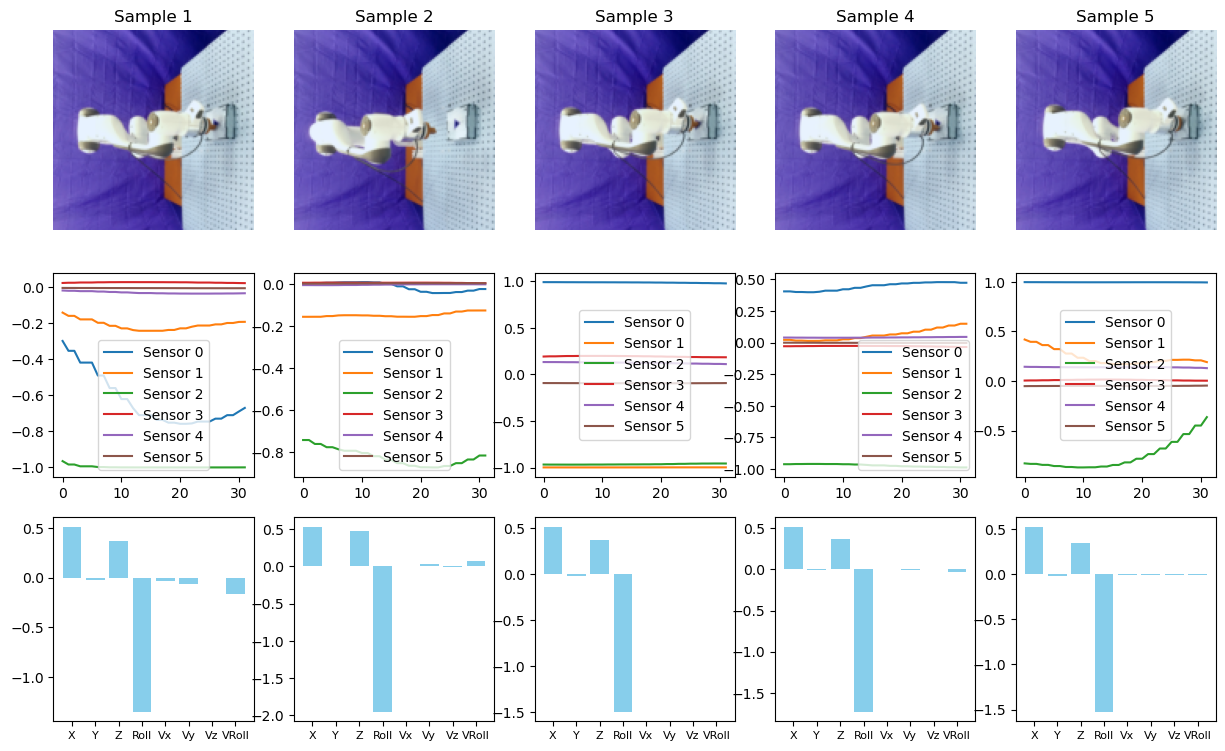

In [21]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # 3 rows (images, force, proprioception), 5 samples
def norm(x): 
    return (255 * (x - torch.min(x)) / (torch.max(x) - torch.min(x))).to(int)

for i in range(5):  # Display 5 samples
    sample = downstream_vt.val_dataset[1000*i]
    # --- Vision (Images) ---
    axes[0, i].imshow(norm(sample[0][0].transpose(0, -1)))
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Sample {i+1}")

    # --- Force-Torque (Time-series for 1 component) ---
    for j in range(6):
        axes[1, i].plot(np.arange(32), sample[0][1][:, j], label=f'Sensor {j}')
    axes[1, i].legend()

    # --- Proprioception (Position & Velocity over Time) ---
    labels = ["X", "Y", "Z", "Roll", "Vx", "Vy", "Vz", "VRoll"]
    # Create bar plot
    axes[2, i].bar(labels, sample[0][2], color='skyblue')
    axes[2, i].tick_params(axis='x', labelsize=8)


## Fit CoMM on Vision&Touch

In [ ]:
def classification_scoring(model, data_module):
    Z_train, y_train = model.extract_features(data_module.train_dataloader())
    Z_val, y_val = model.extract_features(data_module.val_dataloader())
    Z_test, y_test = model.extract_features(data_module.test_dataloader())
    scores = evaluate_linear_probe(Z_train, y_train, Z_test, y_test, Z_val, y_val)
    return scores["acc1"]

In [24]:
comm = CoMM(
    encoder=MMFusion(
        encoders=[ # Handles vision and textual modalities
           timm.create_model(
               model_name="resnet18",
               pretrained=False,
               num_classes=0,
               global_pool=""),
            ForceEncoder(
                z_dim=512
            ),
            ProprioEncoder(
                z_dim=512
            ) 
        ], 
        input_adapters=[
            PatchedInputAdapter(
                num_channels=512, # nb of feature maps
                stride_level=1,
                patch_size_full=1,
                dim_tokens=512,
                image_size=4), 
            SimpleFeaturesInputAdapter(), 
            SimpleFeaturesInputAdapter()], # No adapters needed
        embed_dim=512
    ),
    projection=CoMM._build_mlp(512, 512, 256),
    optim_kwargs=dict(lr=1e-4, weight_decay=1e-2),
    loss_kwargs=dict(temperature=0.1)
)

/home/bdufumier/miniconda3/envs/multimodal/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987301168/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [37]:
trainer = Trainer(inference_mode=False, max_epochs=100)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(comm, datamodule=data_module_vt)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | MMFusion   | 14.8 M
1 | head    | Sequential | 658 K 
2 | loss    | CoMMLoss   | 0     
---------------------------------------
15.5 M    Trainable params
8.2 K     Non-trainable params
15.5 M    Total params
61.961    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [36]:
score = classification_scoring(comm.to("cuda"), downstream_vt)

In [ ]:
print(f"CoMM accuracy on Vision&Touch={100 * score:.2f}")